In [1]:
import os
import shutil

from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from affine import Affine
from shapely.geometry import Point, Polygon
from transforms3d import affines
import pandas as pd
import seaborn as sns


# Estimate metrics

In [2]:
def get_affine(pts1, pts2, thrs):
    if len(pts1) < 2 or len(pts2) < 2:
        return None, np.zeros(len(pts1))

    aff, inl = cv2.estimateAffinePartial2D(pts1, pts2, ransacReprojThreshold=thrs, method=cv2.RANSAC)

    if aff is None:
        return None, np.zeros(len(pts1))

    affine_transform = Affine(
        a=aff[0, 0], b=aff[0, 1], c=aff[0, 2],
        d=aff[1, 0], e=aff[1, 1], f=aff[1, 2],
    )
    inl = inl.squeeze()
    return affine_transform, inl

def get_reprojection_error(pts1, pts2):
    def euclidean_difference(points1, points2):
        return np.sqrt(np.sum((points1 - points2)**2, axis=1))

    differences = euclidean_difference(pts1, pts2)
    return np.mean(differences)

def get_distinct_pts_error(transform, center_only=False):
    if center_only:
        pts = np.array([
            [160, 120]
        ])
    else:
        pts = np.array([
        [0, 0],
        [320, 0],
        [320, 240],
        [0, 240]
    ])
    pts_warp = np.apply_along_axis(lambda x: transform * x, 1, pts)
    error = get_reprojection_error(pts, pts_warp)
    return error

def get_affine_components_error(transform):
    transform_matrix = np.array([
        [transform.a, transform.b, transform.c],
        [transform.d, transform.e, transform.f],
        [0, 0, 1]
    ])
    T, R, Z, S = affines.decompose(transform_matrix)


    translation_error = np.sqrt(np.sum(np.square(T)))
    rotation_error = np.abs(np.rad2deg(np.arccos(R[0, 0])))
    zoom_error = Z[0] - 1
    shear_error = S[0]
    return translation_error, rotation_error, zoom_error, shear_error


In [3]:
def estimate_metrics(kpts0, kpts1, matches0, ransac_thr=5):
    matched_kpts0 = kpts0[matches0>0]
    matched_kpts1 = kpts1[matches0[matches0>0]]
    total_reprojection_error = get_reprojection_error(matched_kpts0, matched_kpts1)
    matches_count = sum(matches0>0)

    transform, inl_ids = get_affine(matched_kpts0, matched_kpts1, ransac_thr)
    if not transform:
        inl_reprojection_error = None
        inl_count = None
        edges_error = None
        center_error = None
        translation_error, rotation_error, zoom_error, shear_error = 4*[None]

    else:

        inl_kpts0 = matched_kpts0[inl_ids>0]
        inl_kpts1 = matched_kpts1[inl_ids>0]
        inl_reprojection_error = get_reprojection_error(inl_kpts0, inl_kpts1)
        inl_count = sum(inl_ids)

        edges_error = get_distinct_pts_error(transform)
        center_error = get_distinct_pts_error(transform, center_only=True)

        translation_error, rotation_error, zoom_error, shear_error = get_affine_components_error(transform)

    return {
        "pts0_count": len(kpts0),
        "pts1_count": len(kpts1),
        "matched_count": matches_count,
        "matched_error": total_reprojection_error,

        "inliers_count": inl_count,
        "inliers_error": inl_reprojection_error,

        "corners_error": edges_error,
        "center_error": center_error,

        "affine_translation_error": translation_error,
        "affine_rotation_error": rotation_error,
        # "affine_zoom_error": zoom_error,
        # "affine_shear_error": shear_error
    }


#### luftronix, satellites, dji

**not the most important dataset, skip and run OpenAerialMap (below)**

In [4]:
inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_0030_single_dom"
# inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_0030_cross_dom"
# inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_0030"


inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_luft_single_domain"
inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_luft_cross_domain"

inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_allval_single_domain"
inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_allval_cross_domain"

inference_results_folder = "/home/topkech/work/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_odm_cross_domain_sg_bigbigsteponecycle_9000"


In [5]:
np_files = [el for el in os.listdir(inference_results_folder) if el.endswith('npz')]
set(el.split('-')[0] for el in np_files)


{'0010',
 '0012',
 '0013',
 '0015',
 '0016',
 '0017',
 '0022',
 '0023',
 '0025',
 '0026',
 '0029',
 '0032',
 '0034',
 '0035',
 '0036',
 '0046',
 '0049',
 '0050',
 '0051',
 '0054',
 '0065',
 '0072',
 '0073',
 '0079',
 '0080',
 '0084',
 '0085',
 '0086',
 '0087',
 '0088',
 '0089',
 '0090',
 '0091',
 '0092',
 '0093',
 '0094',
 '0098',
 '0111',
 '0116',
 '0120',
 '0121',
 '0122',
 '0124',
 '0125',
 '0127',
 '0129',
 '0130',
 '0131',
 '0132',
 '0133',
 '0137',
 '0143',
 '0146',
 '0147',
 '0148',
 '0150',
 '0151',
 '0152',
 '0155',
 '0157',
 '0161',
 '0162',
 '0163',
 '0171',
 '0173',
 '0175',
 '0177',
 '0178',
 '0194',
 '0203',
 '0218',
 '0247',
 '0257',
 '0262',
 '0286',
 '0293',
 '0294',
 '0305',
 '0323',
 '0324',
 '0337',
 '0338',
 '0339',
 '0340'}

In [6]:
len(np_files)


1002

In [7]:
metrics = []
for np_filename in tqdm(np_files):
    splits = np_filename.split('-')
    ds_type = splits[0]
    if ds_type == 'luftronix':
        if 'TCI' in np_filename:
            ds_type = 'Luftronix to Sentinel'
        else:
            ds_type = 'Luftronix to PlanetScope'
        luft_ds = splits[-4]
        ds_type = luft_ds + " " + ds_type


    elif ds_type=='dji':
        ds_type = "DJI to PS BaseMap"
    elif ds_type=='matrice':
        ds_type = 'Matrice to PS BaseMap'
    else:
        ds_type = 'SkySat to ' + ds_type.capitalize()

    npz_path = os.path.join(inference_results_folder, np_filename)
    npz_content = dict(np.load(npz_path))
    kpts0 = npz_content['kpts0']
    kpts1 = npz_content['kpts1']
    matches0 = npz_content['matches']

    metrics_row = estimate_metrics(kpts0, kpts1, matches0, ransac_thr=10)
    metrics_row['dataset'] = ds_type
    metrics.append(metrics_row)


  0%|          | 0/1002 [00:00<?, ?it/s]/home/topkech/mambaforge/envs/spsg/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/topkech/mambaforge/envs/spsg/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1002/1002 [00:00<00:00, 1034.92it/s]


In [8]:
metrics = pd.DataFrame(metrics)
metrics.head(2)


,pts0_count,pts1_count,matched_count,matched_error,inliers_count,inliers_error,corners_error,center_error,affine_translation_error,affine_rotation_error,dataset
0,143,86,35,56.520844,14.0,4.115200,3.817699,2.005021,5.564636,0.886656,SkySat to 0012
1,151,120,27,37.300114,15.0,8.823193,8.176433,6.963574,3.376390,0.963677,SkySat to 0129


In [9]:
metrics['dataset'].value_counts()


dataset
SkySat to 0013    256
SkySat to 0012    216
SkySat to 0015     81
SkySat to 0132     67
SkySat to 0054     26
                 ... 
SkySat to 0162      1
SkySat to 0157      1
SkySat to 0146      1
SkySat to 0194      1
SkySat to 0086      1
Name: count, Length: 84, dtype: int64

In [10]:
metrics[metrics['matched_count']==metrics['matched_count'].max()]


,pts0_count,pts1_count,matched_count,matched_error,inliers_count,inliers_error,corners_error,center_error,affine_translation_error,affine_rotation_error,dataset
407,310,231,173,2.702775,170.0,2.450915,1.219875,0.707375,0.489931,0.060316,SkySat to 0054


In [11]:
metrics_cols = list(metrics.columns)
metrics_cols.pop(-1)
print(metrics_cols)


['pts0_count', 'pts1_count', 'matched_count', 'matched_error', 'inliers_count', 'inliers_error', 'corners_error', 'center_error', 'affine_translation_error', 'affine_rotation_error']


In [12]:
datasets = sorted(list(metrics['dataset'].unique()))
print(datasets)


['SkySat to 0010', 'SkySat to 0012', 'SkySat to 0013', 'SkySat to 0015', 'SkySat to 0016', 'SkySat to 0017', 'SkySat to 0022', 'SkySat to 0023', 'SkySat to 0025', 'SkySat to 0026', 'SkySat to 0029', 'SkySat to 0032', 'SkySat to 0034', 'SkySat to 0035', 'SkySat to 0036', 'SkySat to 0046', 'SkySat to 0049', 'SkySat to 0050', 'SkySat to 0051', 'SkySat to 0054', 'SkySat to 0065', 'SkySat to 0072', 'SkySat to 0073', 'SkySat to 0079', 'SkySat to 0080', 'SkySat to 0084', 'SkySat to 0085', 'SkySat to 0086', 'SkySat to 0087', 'SkySat to 0088', 'SkySat to 0089', 'SkySat to 0090', 'SkySat to 0091', 'SkySat to 0092', 'SkySat to 0093', 'SkySat to 0094', 'SkySat to 0098', 'SkySat to 0111', 'SkySat to 0116', 'SkySat to 0120', 'SkySat to 0121', 'SkySat to 0122', 'SkySat to 0124', 'SkySat to 0125', 'SkySat to 0127', 'SkySat to 0129', 'SkySat to 0130', 'SkySat to 0131', 'SkySat to 0132', 'SkySat to 0133', 'SkySat to 0137', 'SkySat to 0143', 'SkySat to 0146', 'SkySat to 0147', 'SkySat to 0148', 'SkySat t

In [13]:
# datasets = [ 'Luftronix to PlanetScope', 'Luftronix to Sentinel', 'SkySat to Planetscope', 'SkySat to Sentinel']
# datasets = [ 'Luftronix to PlanetScope', 'Luftronix to Sentinel']

# datasets = ['0028 Luftronix to PlanetScope', '0030 Luftronix to PlanetScope', '0083 Luftronix to PlanetScope']
datasets = ['SkySat to Planetscope', 'SkySat to Sentinel']


#### OpenAerialMap

In [14]:
# inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_odm_cross_domain"
# inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_odm_single_domain"
# inference_results_folder = "/home/quantum/Projects/VisNavigate/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_odm_cross_domain_new"
inference_results_folder = "/home/topkech/work/satellite_navigation_superglue/SuperGluePretrainedNetwork/output_odm_cross_domain_sg_bigbigsteponecycle_9000"


In [15]:
np_files = [el for el in os.listdir(inference_results_folder) if el.endswith('npz')]
set(el.split('-')[6] for el in np_files)


{'140', '280', '500', '800'}

In [16]:
cover2height = {140: 100, 280: 200, 500: 350, 800: 500}
baselines_folder = "/home/topkech/work/sat_datasets/cross-domain-preprocessed-2023-08-23/basemaps"  # deleted bad basemaps

metrics = []
for np_filename in tqdm(np_files):
    splits = np_filename.split('-')
    oam_name = f"{splits[0]}_{splits[1]}_{splits[2]}-{splits[3]}-{splits[4]}"
    if oam_name not in os.listdir(baselines_folder):
        continue

    coverage = splits[6]
    altitude = cover2height[int(coverage)]

    ds_type = f'Image from {altitude} m (footprint {coverage} m)'

    npz_path = os.path.join(inference_results_folder, np_filename)
    npz_content = dict(np.load(npz_path))
    kpts0 = npz_content['kpts0']
    kpts1 = npz_content['kpts1']
    matches0 = npz_content['matches']

    metrics_row = estimate_metrics(kpts0, kpts1, matches0, ransac_thr=10)
    metrics_row['dataset'] = ds_type
    metrics.append(metrics_row)


  0%|          | 0/1002 [00:00<?, ?it/s]/home/topkech/mambaforge/envs/spsg/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/topkech/mambaforge/envs/spsg/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1002/1002 [00:00<00:00, 1007.38it/s]


In [17]:
metrics = pd.DataFrame(metrics)
metrics.head(2)


,pts0_count,pts1_count,matched_count,matched_error,inliers_count,inliers_error,corners_error,center_error,affine_translation_error,affine_rotation_error,dataset
0,143,86,35,56.520844,14.0,4.115200,3.817699,2.005021,5.564636,0.886656,Image from 200 m (footprint 280 m)
1,151,120,27,37.300114,15.0,8.823193,8.176433,6.963574,3.376390,0.963677,Image from 500 m (footprint 800 m)


In [18]:
metrics['dataset'].value_counts()


dataset
Image from 200 m (footprint 280 m)    337
Image from 100 m (footprint 140 m)    316
Image from 350 m (footprint 500 m)    295
Image from 500 m (footprint 800 m)     54
Name: count, dtype: int64

In [19]:
# if you want to plot all metrics (don't informative)

metrics_cols = list(metrics.columns)
metrics_cols.pop(-1)
print(metrics_cols)


['pts0_count', 'pts1_count', 'matched_count', 'matched_error', 'inliers_count', 'inliers_error', 'corners_error', 'center_error', 'affine_translation_error', 'affine_rotation_error']


In [20]:
# main metrics you would like to check

metrics_cols = ['matched_count', 'matched_error', 'center_error']


In [21]:
datasets = sorted(list(metrics['dataset'].unique()))
print(datasets)


['Image from 100 m (footprint 140 m)', 'Image from 200 m (footprint 280 m)', 'Image from 350 m (footprint 500 m)', 'Image from 500 m (footprint 800 m)']


### Plots

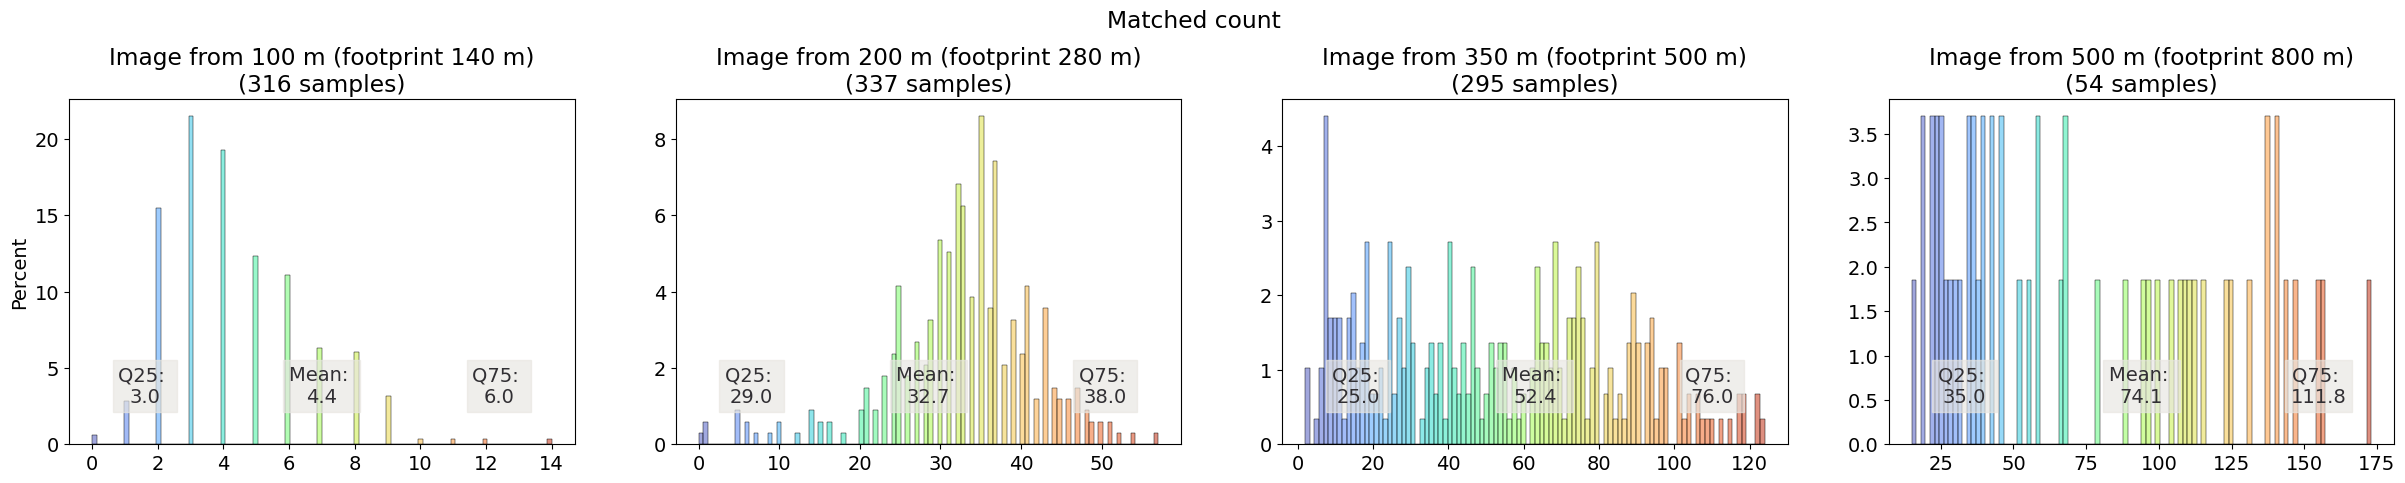

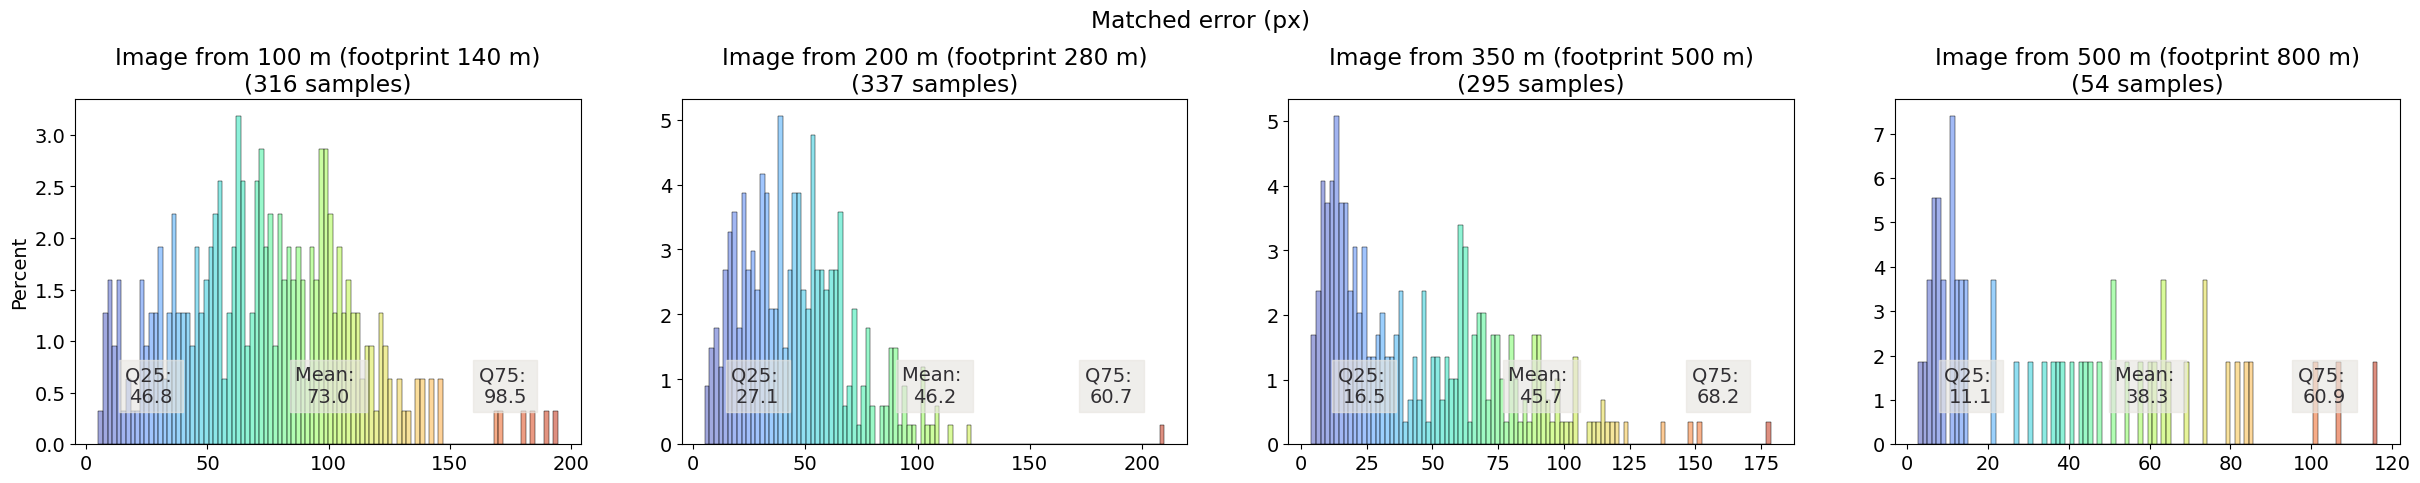

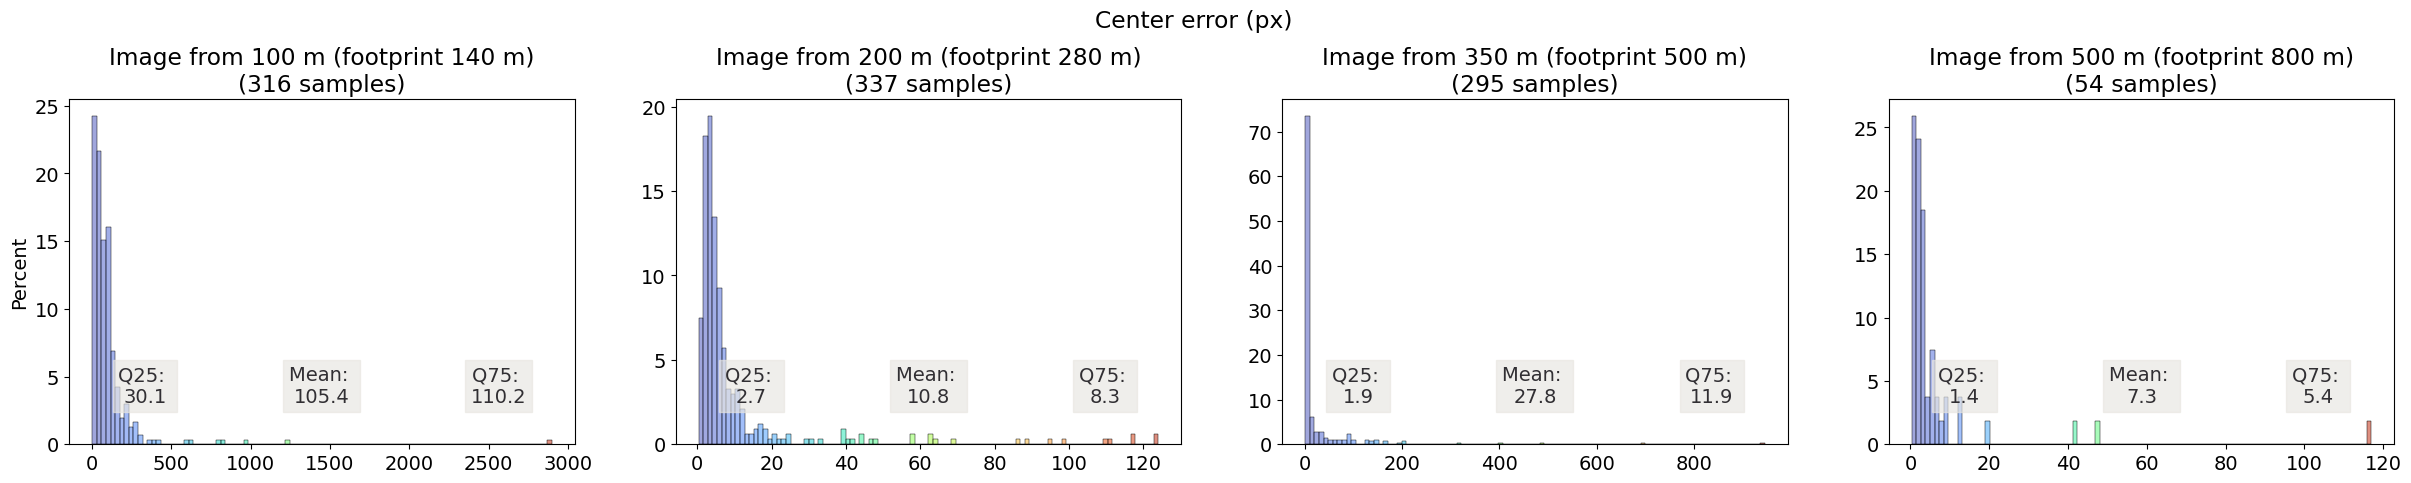

In [22]:
plt.rcParams['font.size'] = 14

for i, metric_name in enumerate(metrics_cols[:]):
    # metric_name = "center_error"
    fig, ax_row = plt.subplots(ncols=len(datasets), figsize=(30, 5))


    for j, (ax, ds) in enumerate(zip(ax_row, sorted(datasets))):
        metrics_ds = metrics[metrics['dataset']==ds]
        hist = sns.histplot(metrics_ds, x=metric_name, ax=ax, alpha=0.3,  stat='percent', color='#27a897', bins=100)
        cmap = plt.get_cmap('turbo')

        for rec_num, rectangle in enumerate(hist.patches):
            rat = (rec_num +len(hist.patches)*0.1 )/(len(hist.patches)*1.2)
            color = list(cmap(rat))
            color[3] = 0.5
            rectangle.set_facecolor(color)

        mean_val = metrics_ds[metric_name].mean()
        # mean_val = metrics_ds[metric_name].quantile(q=0.5)
        p25 =  metrics_ds[metric_name].quantile(q=0.25)
        p75 = metrics_ds[metric_name].quantile(q=0.75)

        center = (ax.get_xlim()[1] - ax.get_xlim()[0]) / 2 + ax.get_xlim()[0]
        left = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.15 + ax.get_xlim()[0]
        right = (ax.get_xlim()[1] - ax.get_xlim()[0]) *0.85 + ax.get_xlim()[0]

        # Annotate the plot with the statistics
        ax.annotate(f'Q25: \n{p25:.1f}', xy=(left, 0), xytext=(0, 30), textcoords='offset points', color="#312f33", backgroundcolor="#e8e6e1AA", ha='center')
        ax.annotate(f'Mean: \n{mean_val:.1f}', xy=(center, 0), xytext=(0, 30), textcoords='offset points', color="#312f33", backgroundcolor="#e8e6e1AA", ha='center')
        ax.annotate(f'Q75: \n{p75:.1f}', xy=(right, 0), xytext=(0, 30), textcoords='offset points', color="#312f33", backgroundcolor="#e8e6e1AA", ha='center')

        ax.set_title(ds + f"\n({len(metrics_ds)} samples)")

        ax.set_xlabel('')
        if j != 0:
            ax.set_ylabel('')

    title = metric_name.capitalize().replace('_', ' ')
    if 'error' in title and "Affine" not in title:
        title = title + ' (px)'
    elif "translat" in title:
        title = title + ' (px)'
    elif "rotat" in title:
        title = title + ' (deg)'

    fig.suptitle(title)
    fig.subplots_adjust(top=0.8)

    # break


In [40]:
# metrics.to_csv('metrics_cross.csv', index=None)
metrics.to_csv('metrics_single.csv', index=None)


### Save results

** cells below were used for extended reports of models perfomance. For "Models testing" spreadsheet we don't use this part.

In [27]:
metrics_single = pd.read_csv('metrics_single.csv')
metrics_cross = pd.read_csv('metrics_cross.csv')


In [28]:
metrics_single.describe().columns


Index(['pts0_count', 'pts1_count', 'matched_count', 'matched_error',
       'inliers_count', 'inliers_error', 'corners_error', 'center_error',
       'affine_translation_error', 'affine_rotation_error',
       'affine_zoom_error', 'affine_shear_error'],
      dtype='object')

In [29]:
metrics_cross['dataset'].value_counts()


Image from 100 m (footprint 140 m)    6870
Image from 200 m (footprint 280 m)    1379
Image from 350 m (footprint 500 m)     297
Image from 500 m (footprint 800 m)      64
Name: dataset, dtype: int64

In [30]:
metric_cols = metrics_single.describe().columns
# datasets = [ 'Luftronix to PlanetScope', 'Luftronix to Sentinel', 'SkySat to Planetscope', 'SkySat to Sentinel']
datasets = metrics_single['dataset'].unique()


In [34]:
metric_cols


Index(['pts0_count', 'pts1_count', 'matched_count', 'matched_error',
       'inliers_count', 'inliers_error', 'corners_error', 'center_error',
       'affine_translation_error', 'affine_rotation_error',
       'affine_zoom_error', 'affine_shear_error'],
      dtype='object')

In [31]:
datasets


array(['Image from 100 m (footprint 140 m)',
       'Image from 200 m (footprint 280 m)',
       'Image from 500 m (footprint 800 m)',
       'Image from 350 m (footprint 500 m)'], dtype=object)

In [32]:
def get_pivot_metrics(series: pd.Series):
    return {
        "mean": series.mean(),
        "25": series.quantile(0.25),
        "median": series.quantile(0.50),
        "75": series.quantile(0.75),
    }


In [33]:
for dataset_name in datasets:

    pivot_table = []

    for metric_name in metrics_cols:
        s_single = metrics_single[metrics_single['dataset']==dataset_name][metric_name]
        pivot_metrics_single = get_pivot_metrics(s_single)
        s_cross = metrics_cross[metrics_cross['dataset']==dataset_name][metric_name]
        pivot_metrics_cross = get_pivot_metrics(s_cross)
        pivot_metrics_single['model'] = 'single'
        pivot_metrics_cross['model'] = 'cross'

        pivot_metrics_single['metric'] = metric_name
        pivot_metrics_cross['metric'] = metric_name

        pivot_table.append(pivot_metrics_single)
        pivot_table.append(pivot_metrics_cross)

    pivot_table = pd.DataFrame(pivot_table)
    # print(pivot_table.head(100))
    pivot_table.to_csv(f"pivot-{dataset_name}.csv", index=None)
    # break
